In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import glob

import seaborn as sns

s_het_paths = {
    'Weghorn-drift': ".../450k/selection_weghorn/weghorn_drift_gencode-v34.txt",
    'Cassa': ".../450k/selection_cassa/cassa_supp_table_1_gencode-v34.txt",
    'PLI': ".../450k/selection_pli/gnomad.v2.1.1.PLI_gencode-v34.txt", 
    "Roulette": ".../450k/selection_roulette/s_het_roulette_gencode-v34.csv",
}

#gene panel
gene_panel = pd.read_csv(".../450k/regions/gene-panel-gencode-v34.txt", header=None)
gene_panel.columns = ['Gene name', 'Gene panel']

gene_panel['Gene panel original'] = gene_panel['Gene panel'].copy()

gene_panel.loc[gene_panel['Gene panel'] != 'ID-total', 'Gene panel'] = 'AR_without_ID'
gene_panel.tail(3)

Gene name     Gene panel Gene panel original
1926       XPC  AR_without_ID            Overlaps
1927  ZMPSTE24  AR_without_ID            Overlaps
1928    ZNF469  AR_without_ID            Overlaps

In [2]:
roulette_s_hets = pd.read_csv(s_het_paths['Roulette'], sep='\t').merge(gene_panel[gene_panel['Gene panel'].isin(['ID-total', 'AR_without_ID'])], 
                                                                       left_on='gene_symbol', right_on='Gene name', how='inner')
roulette_s_hets['Gene panel'].value_counts()

Gene panel
AR_without_ID    1533
ID-total          357
Name: count, dtype: int64

<Axes: xlabel='Gene panel', ylabel='s_het'>

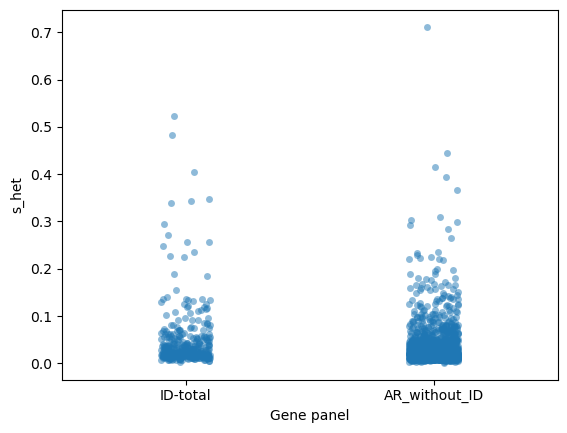

In [3]:
sns.stripplot(data=roulette_s_hets, x='Gene panel', y='s_het', jitter=True, alpha=0.5)

In [47]:
roulette_s_hets.groupby('Gene panel')['s_het'].mean()

Gene panel
AR_without_ID    0.034735
ID-total         0.047510
Name: s_het, dtype: float64

In [24]:
n_samples = 20
random_state = 42
# random_state = 1


# Define bin edges
accepted_id_list = ['EIF4A3', 'SOBP']
accepted_non_id_list = ['PRKDC']
accepted_panels = [roulette_s_hets[roulette_s_hets['Gene name'].isin(accepted_id_list)].copy()]

for idx in range(n_samples):
    sample = roulette_s_hets[roulette_s_hets['Gene name'].isin(accepted_non_id_list)].copy()
    sample['Gene panel'] = f'AR_without_ID_{idx}'

    accepted_panels.append(sample)
    
accepted_panels = pd.concat(accepted_panels)

bin_edges = np.arange(0, 0.9, 0.05)

# # Assign each row to a bin
roulette_s_hets['s_het_bin'] = pd.cut(roulette_s_hets['s_het'], bins=bin_edges, include_lowest=True, right=False)

sampled_data = []

for bin in roulette_s_hets['s_het_bin'].unique():
    bin_data = roulette_s_hets[roulette_s_hets['s_het_bin'] == bin].copy()

    min_size = bin_data.groupby('Gene panel').size().min()

    if bin_data['Gene panel'].unique().size < 2:
        # print(bin_data[['Gene name', 'Gene panel']])
        continue

    sampled_min_size = [bin_data[bin_data['Gene panel'] == 'ID-total'].sample(min_size, random_state=random_state)]
    
    for idx in range(n_samples):
        sample = bin_data[bin_data['Gene panel'] == 'AR_without_ID'].sample(min_size).copy()
        sample['Gene panel'] = f'AR_without_ID_{idx}'

        sampled_min_size.append(sample)

    sampled_min_size = pd.concat(sampled_min_size)

    sampled_data.append(sampled_min_size) 

    print (bin, bin_data.groupby('Gene panel').size()['ID-total'], bin_data.groupby('Gene panel').size()['AR_without_ID'])
    # break

sampled_data = pd.concat(sampled_data)
sampled_data = pd.concat([sampled_data, accepted_panels])


rename_dict = {k: f'{k.split('-')[0]}_sampled' for k in sampled_data['Gene panel'].unique()}
sampled_data['Gene panel'] = sampled_data['Gene panel'].apply(lambda x: rename_dict[x])

[0.0, 0.05) 265 1281
[0.05, 0.1) 55 164
[0.1, 0.15) 20 45
[0.4, 0.45) 1 2
[0.2, 0.25) 4 8
[0.15, 0.2) 3 24
[0.3, 0.35) 3 2
[0.25, 0.3) 4 4


<Axes: xlabel='s_het', ylabel='Gene panel'>

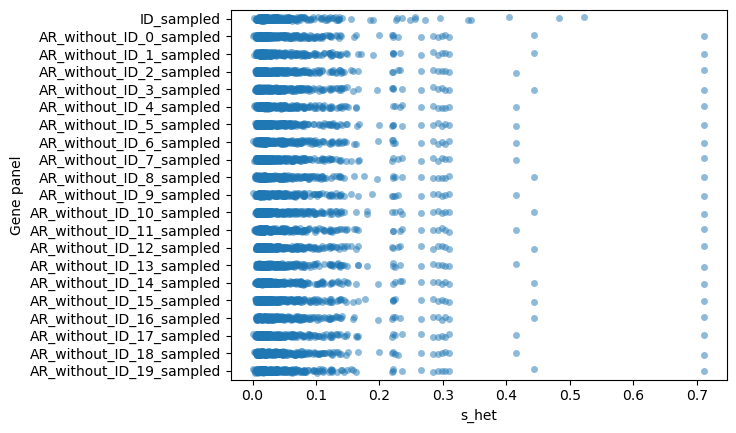

In [28]:
sns.stripplot(data=sampled_data, y='Gene panel', x='s_het', jitter=True, alpha=0.5)
# plt.xticks(rotation=45)

<Axes: xlabel='s_het', ylabel='Gene panel'>

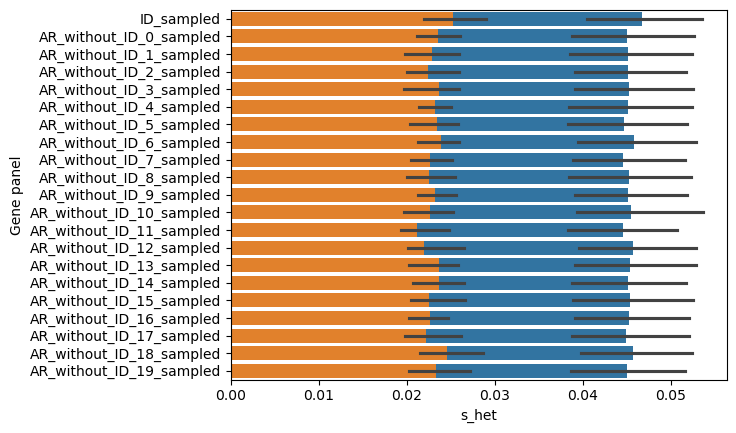

In [30]:
sns.barplot(data=sampled_data, y='Gene panel', x='s_het', estimator=np.mean)
sns.barplot(data=sampled_data, y='Gene panel', x='s_het', estimator=np.median)

In [31]:
sampled_data.groupby('Gene panel')['s_het'].mean()

Gene panel
AR_without_ID_0_sampled     0.045030
AR_without_ID_10_sampled    0.045448
AR_without_ID_11_sampled    0.044568
AR_without_ID_12_sampled    0.045629
AR_without_ID_13_sampled    0.045379
AR_without_ID_14_sampled    0.045084
AR_without_ID_15_sampled    0.045368
AR_without_ID_16_sampled    0.045274
AR_without_ID_17_sampled    0.044930
AR_without_ID_18_sampled    0.045680
AR_without_ID_19_sampled    0.045023
AR_without_ID_1_sampled     0.045064
AR_without_ID_2_sampled     0.045117
AR_without_ID_3_sampled     0.045264
AR_without_ID_4_sampled     0.045073
AR_without_ID_5_sampled     0.044676
AR_without_ID_6_sampled     0.045822
AR_without_ID_7_sampled     0.044568
AR_without_ID_8_sampled     0.045198
AR_without_ID_9_sampled     0.045063
ID_sampled                  0.046666
Name: s_het, dtype: float64

In [32]:
sampled_data['Gene panel'].value_counts()

Gene panel
ID_sampled                  356
AR_without_ID_0_sampled     355
AR_without_ID_1_sampled     355
AR_without_ID_2_sampled     355
AR_without_ID_3_sampled     355
AR_without_ID_4_sampled     355
AR_without_ID_5_sampled     355
AR_without_ID_6_sampled     355
AR_without_ID_7_sampled     355
AR_without_ID_8_sampled     355
AR_without_ID_9_sampled     355
AR_without_ID_10_sampled    355
AR_without_ID_11_sampled    355
AR_without_ID_12_sampled    355
AR_without_ID_13_sampled    355
AR_without_ID_14_sampled    355
AR_without_ID_15_sampled    355
AR_without_ID_16_sampled    355
AR_without_ID_17_sampled    355
AR_without_ID_18_sampled    355
AR_without_ID_19_sampled    355
Name: count, dtype: int64

In [33]:
sampled_data['Gene panel original'].value_counts()

Gene panel original
Metabolic-ID             1554
Metabolic                1435
Overlaps                 1221
Neuromuscular             549
Immune_system             431
ID-total                  356
Blindness                 351
Cilia+Kidney              314
Skeletal+Craniofacial     303
Derm                      299
Hematologic               193
Deafness                  165
Endocrine                 147
Cardiovascular             77
No_panel                   46
Tumor                      15
Name: count, dtype: int64

In [34]:
sampled_data['Gene panel original'].value_counts()

Gene panel original
Metabolic-ID             1554
Metabolic                1435
Overlaps                 1221
Neuromuscular             549
Immune_system             431
ID-total                  356
Blindness                 351
Cilia+Kidney              314
Skeletal+Craniofacial     303
Derm                      299
Hematologic               193
Deafness                  165
Endocrine                 147
Cardiovascular             77
No_panel                   46
Tumor                      15
Name: count, dtype: int64

In [35]:
sampled_data[['Gene name', 'Gene panel']].to_csv('.../450k/regions/gene-panel-gencode-v34.sampled.txt', sep=',', index=False)

# Look at the distibutions

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import glob

import seaborn as sns

from ukbb_recessive.data_collection.variants import VariantFeatures

variant_features = VariantFeatures()

variants_paths_cfg = {
    'recessive' : {
        'cohort_files': glob.glob(".../450k/RAP_output_per_chr/filtered_plps/basic/new_gene_names/new_freq/new_relatedness/chr*"), 
        'all_variants_file': ".../450k/plp_selection/basic/new_gene_names/new_freq/new_relatedness/all_chr_total_presumable_plps_HFE_final_sorted.txt"
    }
}

with open(".../450k/samples/european_non_related_no_withdrawal_to_include_450k.no_hom_comp_het.txt", 'r') as f:
    samples = [l.strip() for l in f.readlines()]

print ("Number of samples:", len(samples))

Number of samples: 376608


In [6]:
sampeld_panel = pd.read_csv('.../450k/regions/gene-panel-gencode-v34.sampled.txt')

sampeld_panel['Gene panel'].value_counts()

Gene panel
sampled_ID               356
sampled_AR_without_ID    355
Name: count, dtype: int64

In [39]:
# select rare PLPs
rare_plps = variant_features.collect_rare_plps(het_occurence_threshold=20,
                                               hom_occurence_threshold=0,
                                                all_plps_file=variants_paths_cfg['recessive']['all_variants_file'],
                                                s_het_file=s_het_paths['Roulette'],
                                                genes_list=None)

rare_plps = rare_plps.merge(sampeld_panel, left_on='gene', right_on='Gene name', how='inner')


Entering `collect_rare_plps` function...
Initial total numbers of PLPs: 54758
Total numbers rare PLPs using <treshold=20>: 50568
Function `collect_rare_plps` finished.



In [40]:
gene_rare_plps = rare_plps.groupby('gene').agg({'s_het': 'first', 'Gene panel': 'first', 'hets': 'max'}).reset_index()

<Axes: xlabel='hets', ylabel='s_het'>

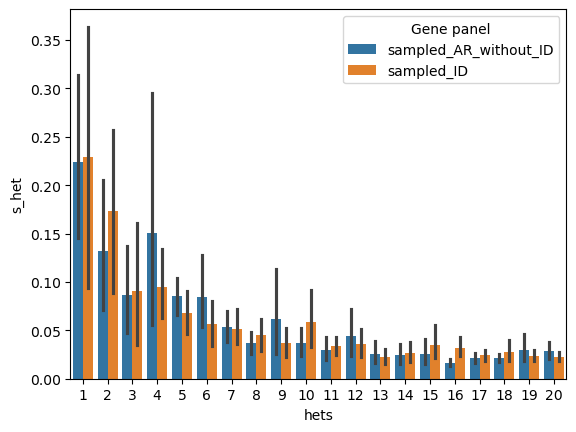

In [45]:
sns.barplot(data=gene_rare_plps, y='s_het', x='hets', hue='Gene panel')